In [73]:
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.regression import *
from torchmetrics.classification import *
from torchmetrics.functional.regression import r2_score
from torchmetrics.functional.classification import f1_score

In [74]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

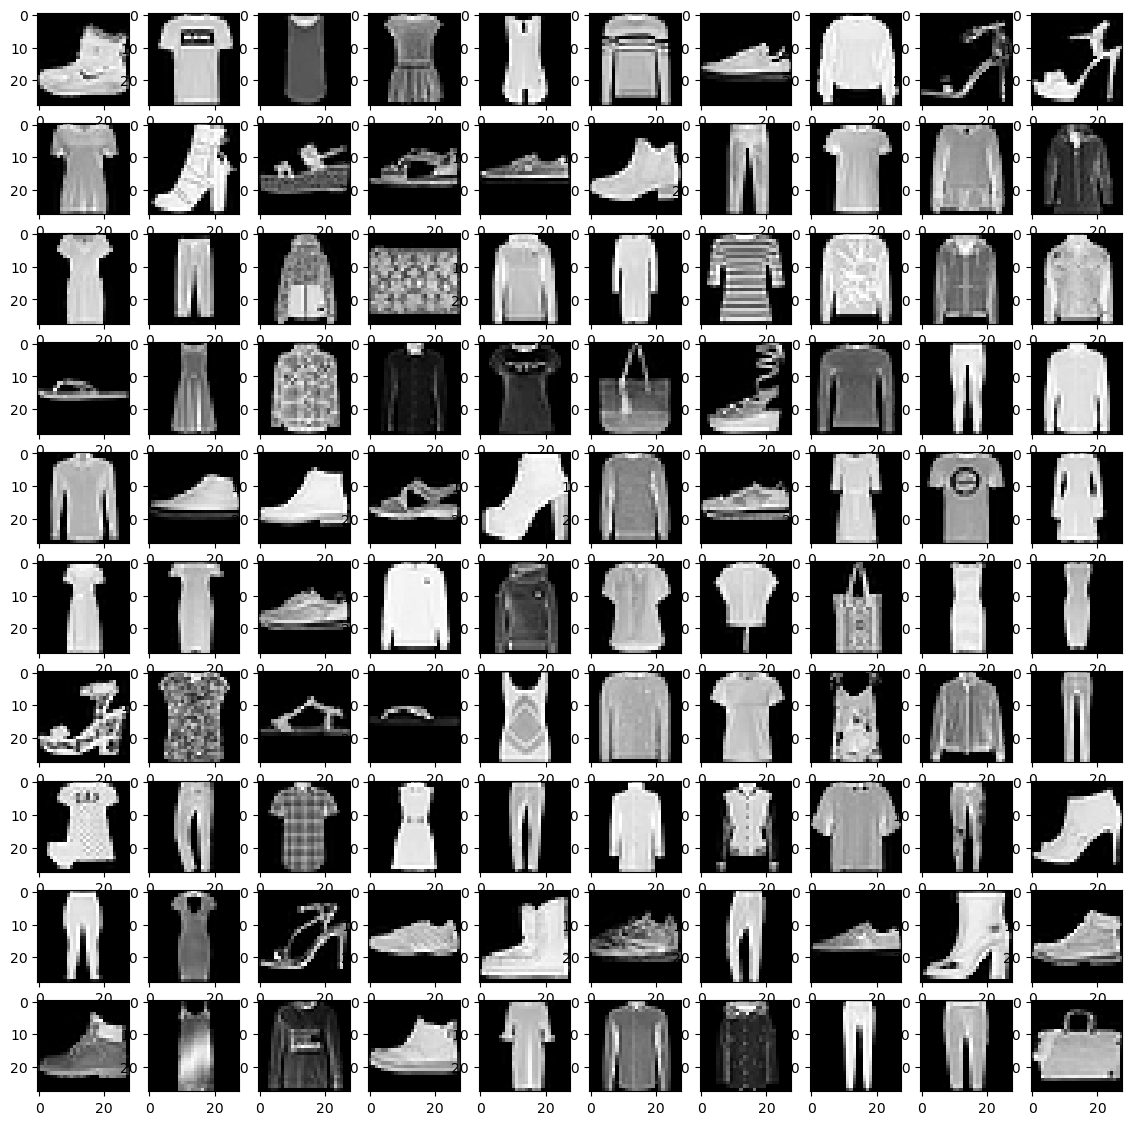

In [75]:
fig, axs = plt.subplots(10,10, figsize = (14, 14))

for i in range(10):
    for j in range(10):
        axs[i][j].imshow(train_input[i*10+j].reshape(28,28), cmap='gray')
plt.show()

In [76]:
torch.manual_seed(1) # 시드 설정

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE : {DEVICE}')

DEVICE : cpu


In [77]:
train_inputDF = pd.DataFrame((train_input/255).reshape(train_input.shape[0],-1))
train_targetDF = pd.DataFrame(train_target.copy().reshape(-1,1))
test_inputDF = pd.DataFrame((test_input/255).reshape(test_input.shape[0],-1))
test_targetDF = pd.DataFrame(test_target.copy().reshape(-1,1))

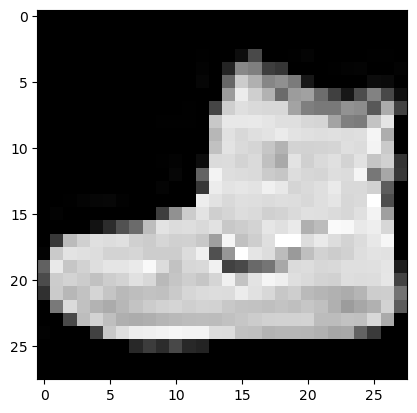

In [78]:
plt.imshow(train_inputDF.iloc[0,:].values.reshape(28,-1), cmap='gray')

In [79]:
print(f"train_input : {train_inputDF.shape}, train_target : {train_targetDF.shape}")
print(f"test_input : {test_inputDF.shape}, test_target : {test_targetDF.shape}")

train_input : (60000, 784), train_target : (60000, 1)
test_input : (10000, 784), test_target : (10000, 1)


In [80]:
# 데이터셋 생성
from DataSet import CustomDataset

trainDS = CustomDataset(train_inputDF, train_targetDF)
testDS = CustomDataset(test_inputDF, test_targetDF)

# 데이터셋 속성
print(f"trainDS shape : ({trainDS.n_rows}, {trainDS.n_features})")
print(f"testDS : ({testDS.n_rows}, {testDS.n_features})")

# 데이터로더 인스턴스 생성
trainDL = DataLoader(trainDS, batch_size=32)
testDL = DataLoader(testDS, batch_size=32)

trainDS shape : (60000, 784)
testDS : (10000, 784)


In [81]:
# 모델 인스턴스 생성
from CustomModel import DeepModel

model = DeepModel(input_in=784, output_out=10, hidden_list=[100, 80, 60, 40, 20],
                  act_func=F.relu, is_reg=False, is_bin=False)
print(model)
summary(model)

DeepModel(
  (input_layer): Linear(in_features=784, out_features=100, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=100, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Param #
DeepModel                                --
├─Linear: 1-1                            78,500
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       8,080
│    └─Linear: 2-2                       4,860
│    └─Linear: 2-3                       2,440
│    └─Linear: 2-4                       820
├─Linear: 1-3                            210
Total params: 94,910
Trainable params: 94,910
Non-trainable params: 0

In [82]:
for feature, target in trainDL:
    print(feature, target, sep='\n')
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[9.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [7.],
        [2.],
        [5.],
        [5.],
        [0.],
        [9.],
        [5.],
        [5.],
        [7.],
        [9.],
        [1.],
        [0.],
        [6.],
        [4.],
        [3.],
        [1.],
        [4.],
        [8.],
        [4.],
        [3.],
        [0.],
        [2.],
        [4.],
        [4.],
        [5.],
        [3.]])


In [83]:
# 옵티마이저 (모델의 가중치 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.00001)
# 가중치, 절편을 전달하고 학습률을 설정

# 모델 훈련
from TorchTrainTest import training, testing
EPOCH = 300
result = training(trainDL, testDL, model, adam_optim, EPOCH,
                  is_reg=False, is_bin=False, num_classes=10)

[Loss : 1/300] Train : 2.1818, Test : 1.8399
[Score  : 1/300] Train : 0.1596, Test : 0.3105
[Loss : 2/300] Train : 1.5846, Test : 1.4364
[Score  : 2/300] Train : 0.3665, Test : 0.3819
[Loss : 3/300] Train : 1.3083, Test : 1.2091
[Score  : 3/300] Train : 0.4778, Test : 0.5171
[Loss : 4/300] Train : 1.1137, Test : 1.0601
[Score  : 4/300] Train : 0.5647, Test : 0.6152
[Loss : 5/300] Train : 0.9991, Test : 0.9748
[Score  : 5/300] Train : 0.6332, Test : 0.6413
[Loss : 6/300] Train : 0.9290, Test : 0.9200
[Score  : 6/300] Train : 0.6549, Test : 0.6648
[Loss : 7/300] Train : 0.8812, Test : 0.8793
[Score  : 7/300] Train : 0.6756, Test : 0.6843
[Loss : 8/300] Train : 0.8433, Test : 0.8458
[Score  : 8/300] Train : 0.6947, Test : 0.6994
[Loss : 9/300] Train : 0.8108, Test : 0.8164
[Score  : 9/300] Train : 0.7106, Test : 0.7139
[Loss : 10/300] Train : 0.7820, Test : 0.7901
[Score  : 10/300] Train : 0.7230, Test : 0.7239
[Loss : 11/300] Train : 0.7563, Test : 0.7669
[Score  : 11/300] Train : 0.7332

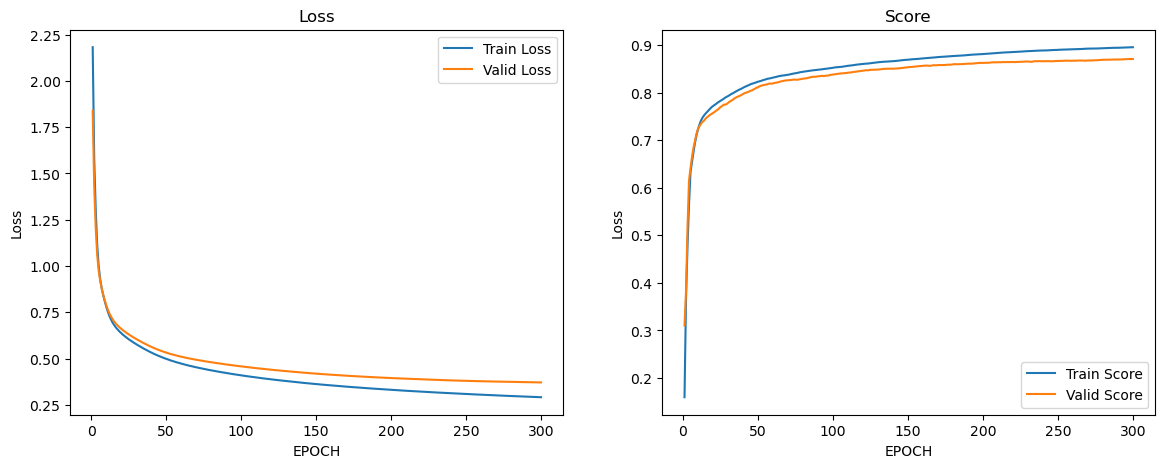

In [84]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

label_list = ['Loss', 'Score']

for i in range(2):
    axs[i].plot(range(1, EPOCH+1), result[2*i], label = f'Train {label_list[i]}')
    axs[i].plot(range(1, EPOCH+1), result[2*i+1], label = f'Valid {label_list[i]}')
    axs[i].set_title(label_list[i])
    axs[i].set_xlabel('EPOCH')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
plt.show()